#Initialise libraries

In [15]:
#Download Pytorch Geometric

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 48 kB 2.4 MB/s 


In [245]:
#Import the libraries
import os
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx

import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from scipy.ndimage.filters import gaussian_filter1d
from collections import namedtuple

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

import sklearn
import torch.nn.utils.prune as prune
from tqdm import tqdm


#Data Preparation

In [19]:
#Set seed 
np.random.seed(1234)

#Generate a random NetworkX graph
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

    #Reference [1]: https://stackoverflow.com/questions/61958360/how-to-create-random-graph-where-each-node-has-at-least-1-edge-using-networkx

In [20]:
np.random.seed(1234)

#Create 200 graphs with 5 nodes
for i in range(1, 200):
  j = 0
  # j = j/10
  k = random.randint(1,42)
  globals()['G_'+str(i)] = gnp_random_connected_graph(5, j) 

In [21]:
#Define node attributes
#Randomise x and y coordinates for each of the 5 nodes
np.random.seed(1234)


for i in range(1,200):

  x_cord_0 =  random.randint(50,60)
  x_cord_1 = random.randint(45,50)
  x_cord_2 = random.randint(40,50)
  x_cord_3 = random.randint(10,20)
  x_cord_4 = random.randint(10,20)
  
  y_cord_0 = random.randint(60,70)
  y_cord_1 = random.randint(40,50)
  y_cord_2 = random.randint(50,60)
  y_cord_3 = random.randint(60,70)
  y_cord_4 = random.randint(45,50)

#Set node attributes
  pos_x={0:x_cord_0, 1:x_cord_1, 2 :x_cord_2, 3 :x_cord_3, 4:x_cord_4}
  pos_y= {0:y_cord_0, 1:y_cord_1, 2 :y_cord_2, 3 :y_cord_3, 4:y_cord_4}
  nx.set_node_attributes(globals()['G_'+str(i)], pos_x, 'pos_x')
  nx.set_node_attributes(globals()['G_'+str(i)], pos_y, 'pos_y')

In [22]:
#Visualise a graph
def viz(G):
  fig, ax = plt.subplots(figsize = (15,8))
  initialpos = {0:(nx.get_node_attributes(G, "pos_x")[0], nx.get_node_attributes(G, "pos_y")[0]), 1:(nx.get_node_attributes(G, "pos_x")[1], nx.get_node_attributes(G, "pos_y")[1]), 
                2:(nx.get_node_attributes(G, "pos_x")[2], nx.get_node_attributes(G, "pos_y")[2]), 3:(nx.get_node_attributes(G, "pos_x")[3], nx.get_node_attributes(G, "pos_y")[3]), 
                4:(nx.get_node_attributes(G, "pos_x")[4], nx.get_node_attributes(G, "pos_y")[4])}
  nx.draw(G, with_labels = True, pos = initialpos)
  limits=plt.axis('on') # turns on axis
  ax.set_xlim(0,120)
  ax.set_ylim(0,120)
  ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

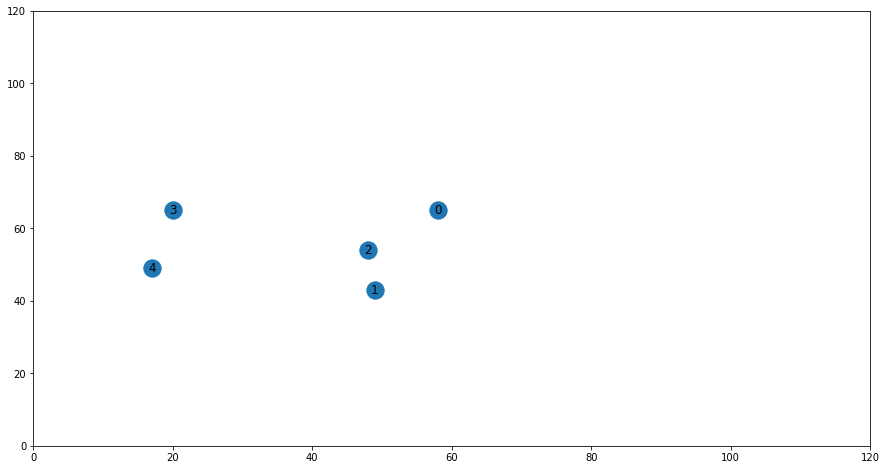

In [23]:
#Visualise graph
viz(G_1)

##MAST formulation

In [24]:
#Adding connections based on the smallest distance(area) between nodes
list_1 = [0,1,2,3,4]
list_2 = [0,1,2,3,4]

def graph_dataset(G): 
  edge_1 = []
  edge_2 = []
  distance = []
  for u in list_1:
    for v in list_2:
      df = pd.DataFrame(columns = ['edge_1','edge_2', 'distance'])
      if(u!=v):
        dist = round((((nx.get_node_attributes(G, 'pos_x')[u]  - nx.get_node_attributes(G, 'pos_x')[v])**2 + (nx.get_node_attributes(G, 'pos_y')[u] - nx.get_node_attributes(G, 'pos_y')[v])**2)**0.5),2)
        # x = random.randint(0, 5)
        # dist = x + dist
        edge_1.append(u)
        edge_2.append(v)
        distance.append(dist)
        
  df['edge_1'] = edge_1
  df['edge_2'] = edge_2
  df['distance'] = distance
  df.drop(df[ (df['edge_1'] == 0) & (df['edge_2'] == 2)].index, inplace = True)
  df.drop(df[ (df['edge_1'] == 0) & (df['edge_2'] == 3)].index, inplace = True)
  df.drop(df[ (df['edge_1'] == 0) & (df['edge_2'] == 4)].index, inplace = True)
  indexes = df[ (df['edge_1'] == 1) & (df['edge_2'] == 0)].index
  df.drop(indexes, inplace = True)
  indexes = df[ (df['edge_1'] == 1) & (df['edge_2'] == 3)].index
  df.drop(indexes, inplace = True)
  indexes = df[ (df['edge_1'] == 1) & (df['edge_2'] == 4)].index
  df.drop(indexes, inplace = True)
  indexes = df[ (df['edge_1'] == 2) & (df['edge_2'] == 0)].index
  df.drop(indexes, inplace = True)
  # indexes = df[ (df['edge_1'] == 2) & (df['edge_2'] == 3) ].index
  # df.drop(indexes, inplace = True)
  # df.drop(df[ (df['edge_1'] == 2) & (df['edge_2'] == 4)].index, inplace = True)
  df.drop(df[ (df['edge_1'] == 2) & (df['edge_2'] == 1)].index, inplace = True)

  df.sort_values(by = ['distance'], inplace = True)

  min_df = pd.DataFrame() 
  for i in df.edge_1.unique():
    globals()['df_'+str(i)] = df[df['edge_1'] == i]
    globals()['df_'+str(i)] = globals()['df_'+str(i)][globals()['df_'+str(i)].distance == globals()['df_'+str(i)].distance.min()]
    min_df = min_df.append(globals()['df_'+str(i)], ignore_index = True)
  
  return min_df


In [25]:
#Iterate the MAST function over the 200 graphs
for i in range(1,200):
  globals()['min_df_'+str(i)] = graph_dataset(globals()['G_'+str(i)])
  globals()['min_df_'+str(i)].sort_values( by = ['edge_1'], inplace = True)
  globals()['min_df_'+str(i)].reset_index (inplace = True)
  globals()['min_df_'+str(i)].drop(columns = ['index'], inplace = True)
 
  



In [26]:
#Further MAST formulation
#Ensuring that the constraint is met, i.e. node x and node y can only be connected if and only if, coverage area of node x & coverage area of node y > distance between x and y
for i in range(1, 200):
    if((globals()['min_df_'+str(i)].iloc[0,0] == 0) & (globals()['min_df_'+str(i)].iloc[0,1] == 1)):
      if(globals()['min_df_'+str(i)].iloc[0,2]>globals()['min_df_'+str(i)].iloc[1,2]): #0,1
        globals()['min_df_'+str(i)].iloc[1,2] = globals()['min_df_'+str(i)].iloc[0,2]
      else:
        globals()['min_df_'+str(i)].iloc[0,2] = globals()['min_df_'+str(i)].iloc[1,2]
    if((globals()['min_df_'+str(i)].iloc[2,0] == 2) & (globals()['min_df_'+str(i)].iloc[2,1] == 3)): #2,3
      if(globals()['min_df_'+str(i)].iloc[2,2]>globals()['min_df_'+str(i)].iloc[3,2]):
        globals()['min_df_'+str(i)].iloc[3,2] = globals()['min_df_'+str(i)].iloc[2,2]
      else:
        globals()['min_df_'+str(i)].iloc[2,2] = globals()['min_df_'+str(i)].iloc[3,2]
    if((globals()['min_df_'+str(i)].iloc[2,0] == 2) & (globals()['min_df_'+str(i)].iloc[2,1] == 4)): #2,4
      if(globals()['min_df_'+str(i)].iloc[2,2]>globals()['min_df_'+str(i)].iloc[4,2]):
        globals()['min_df_'+str(i)].iloc[4,2] = globals()['min_df_'+str(i)].iloc[2,2]
      else:
        globals()['min_df_'+str(i)].iloc[2,2] =globals()['min_df_'+str(i)].iloc[4,2]
  
    
  
 


In [27]:
#Set coverage area as a node attribute for the nodes
for i in range(1,200):
  pow={}
  pow={0:globals()['min_df_'+str(i)]['distance'][0], 1:globals()['min_df_'+str(i)]['distance'][1], 2:globals()['min_df_'+str(i)]['distance'][2], 3:globals()['min_df_'+str(i)]['distance'][3], 4:globals()['min_df_'+str(i)]['distance'][4]}
  nx.set_node_attributes(globals()['G_'+str(i)], pow, 'y')
  

In [28]:
#Adding edges where the constraint is met, i.e. edge exist between a pair of nodes if and only if their individual coverage area is greater than the distance between the pair of nodes
for i in range(1,200):
  globals()['G_'+str(i)].add_edge(0, 1)
  cov_0 = nx.get_node_attributes(globals()['G_'+str(i)], 'y')[0]
  cov_1 = nx.get_node_attributes(globals()['G_'+str(i)], 'y')[1]
  cov_2 = nx.get_node_attributes(globals()['G_'+str(i)], 'y')[2]
  cov_3 = nx.get_node_attributes(globals()['G_'+str(i)], 'y')[3]
  cov_4 = nx.get_node_attributes(globals()['G_'+str(i)], 'y')[4]
  dist_12 = round((((nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[1]  - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[2])**2 + (nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[1] - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[2])**2)**0.5),2)
  dist_23 = round((((nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[2]  - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[3])**2 + (nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[2] - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[3])**2)**0.5),2)
  dist_24 = round((((nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[2]  - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[4])**2 + (nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[2] - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[4])**2)**0.5),2)
  dist_34 = round((((nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[3]  - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[4])**2 + (nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[3] - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[4])**2)**0.5),2)
  if((cov_1 >= dist_12) & (cov_2 >= dist_12)):
    globals()['G_'+str(i)].add_edge(1, 2)
  if((cov_2>=dist_23) & (cov_3>=dist_23)):
    globals()['G_'+str(i)].add_edge(2, 3)  
  if((cov_2>=dist_24) & (cov_4>=dist_24)):
    globals()['G_'+str(i)].add_edge(2, 4)  
  if((cov_3>=dist_34) & (cov_4>=dist_34)):
    globals()['G_'+str(i)].add_edge(3, 4)  

##Converting NetworkX graph to Pytorch Geometric Objects

In [29]:
#Appeding all the graphs to an empty list
Graphs = []
for i in range(1, 200):
  Graphs.append(globals()['G_'+str(i)])

In [30]:
#Convert to PyG objects with features as node coordinates
for i in range(1,199):
  globals()['data_'+str(i)] = from_networkx(Graphs[i],['pos_x','pos_y'])

In [32]:
#List of data for dataloader
data_list = [data_1,	data_2,	data_3,	data_4,	data_5,	data_6,	data_7,	data_8,	data_9,	data_10,	data_11,	data_12,	data_13,	data_14,	data_15,	data_16,	data_17,	data_18,	data_19,	data_20,	data_21,	data_22,	data_23,	data_24,	data_25,	data_26,	data_27,	data_28,	data_29,	data_30,	data_31,	data_32,	data_33,	data_34,	data_35,	data_36,	data_37,	data_38,	data_39,	data_40,	data_41,	data_42,	data_43,	data_44,	data_45,	data_46,	data_47,	data_48,	data_49,	data_50,	data_51,	data_52,	data_53,	data_54,	data_55,	data_56,	data_57,	data_58,	data_59,	data_60,	data_61,	data_62,	data_63,	data_64,	data_65,	data_66,	data_67,	data_68,	data_69,	data_70,	data_71,	data_72,	data_73,	data_74,	data_75,	data_76,	data_77,	data_78,	data_79,	data_80,	data_81,	data_82,	data_83,	data_84,	data_85,	data_86,	data_87,	data_88,	data_89,	data_90,	data_91,	data_92,	data_93,	data_94,	data_95,	data_96,	data_97,	data_98,	data_99,	data_100,	data_101,	data_102,	data_103,	data_104,	data_105,	data_106,	data_107,	data_108,	data_109,	data_110,	data_111,	data_112,	data_113,	data_114,	data_115,	data_116,	data_117,	data_118,	data_119,	data_120,	data_121,	data_122,	data_123,	data_124,	data_125,	data_126,	data_127,	data_128,	data_129,	data_130,	data_131,	data_132,	data_133,	data_134,	data_135,	data_136,	data_137,	data_138,	data_139,	data_140,	data_141,	data_142,	data_143,	data_144,	data_145,	data_146,	data_147,	data_148,	data_149,	data_150,	data_151,	data_152,	data_153,	data_154,	data_155,	data_156,	data_157,	data_158,	data_159,	data_160,	data_161,	data_162,	data_163,	data_164,	data_165,	data_166,	data_167,	data_168,	data_169,	data_170,	data_171,	data_172,	data_173,	data_174,	data_175,	data_176,	data_177,	data_178,	data_179,	data_180,	data_181,	data_182,	data_183,	data_184,	data_185,	data_186,	data_187,	data_188,	data_189,	data_190,	data_191,	data_192,	data_193,	data_194,	data_195,	data_196,	data_197,	data_198]

In [33]:
#Split data into train and test
train_data = data_list[0:190]

test_data = data_list[190:]

In [493]:
#Prepare data before feeding into our GCN 
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#GCN

##Define model

In [553]:
#GCN Architecture
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GATConv(2, 256)
        #self.conv2 = GATConv(256, 128)
        # self.conv3 = GCNConv(128, 56)
        # self.conv4 = GCNConv(56, 28)
        #self.conv3 = GCNConv(data.num_features, 32)
        
        #self.linear1 = torch.nn.Linear(128,64)
        self.conv3 = GCNConv(256,128)
        self.linear1 = torch.nn.Linear(128,64)
        self.linear2 = torch.nn.Linear(64,1)
        #self.linear3 = torch.nn.Linear(32,1)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        #x = self.conv2(x, edge_index)
        #x = x.relu()
        #x = torch.flatten(x)
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv3(x, edge_index)
        # x = x.relu()
        # x = self.conv4(x, edge_index)
        # x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.linear1(x)
        # x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.linear1(x)
        #x= x.relu()
        x = self.linear2(x)
        # x = self.linear3(x)
        #x= x.relu()
        
        return x

In [554]:
#Initialise our GCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(256).to(device)

In [555]:
#Define optimiser
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [556]:
#Model architecture
print(model)

GCN(
  (conv1): GATConv(2, 256, heads=1)
  (conv3): GCNConv(256, 128)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)


##Train our model

In [557]:
#Train our model and evaluate on the test set
train_pred = []
train_values = []
val_pred = []
val_values = []
for e in range(1000):
    print(e)
    model.train()     # Optional when not using Model Specific layer
    for data in train_loader:

      optim.zero_grad()
      data.x = data.x.to(device, dtype = torch.float)
      data.y = data.y.to(device, dtype = torch.float)

      pred = model(data.x, data.edge_index)
      
      loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
      pred_np = pred.detach().numpy()
      data.y_np = data.y.detach().numpy() 
      train_pred.append(pred_np)
      train_values.append(data.y_np)
      loss.backward()
      optim.step()
    
    model.eval()
    for data in train_loader:
           # Optional when not using Model Specific layer
      optim.zero_grad()
      data.x = data.x.to(device, dtype = torch.float)
      data.y = data.y.to(device, dtype = torch.float)
      
      pred = model(data.x, data.edge_index)
      
      loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
      pred_np = pred.detach().numpy()
      data.y_np = data.y.detach().numpy() 
      val_pred.append(pred_np)
      val_values.append(data.y_np)
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

##Visualise learning curves

In [574]:
#Obtain the training/validation curves
def train_graph(pred, train, val_pred, val_train, epochs):

  median_scores_train = []
  median_scores_test = []

  mean_scores_train = []
  mean_scores_test = []

  for i in range(1,epochs):
    median_scores_train.append(median_absolute_error(pred[i], train[i]))
    mean_scores_train.append(mean_absolute_error(pred[i], train[i]))
    median_scores_test.append(median_absolute_error(val_pred[i], val_train[i]))
    mean_scores_test.append(mean_absolute_error(val_pred[i], val_train[i]))

  epoch = []
  for i in range(1,epochs):
    epoch.append(i)

  ysmoothed_median_train = gaussian_filter1d(median_scores_train, sigma=2)
  ysmoothed_mean_train = gaussian_filter1d(mean_scores_train, sigma=2)

  ysmoothed_median_test = gaussian_filter1d(median_scores_test, sigma=2)
  ysmoothed_mean_test = gaussian_filter1d(mean_scores_test, sigma=2)

  plt.rcParams['figure.figsize'] = [7, 7]
  plt.plot(epoch, ysmoothed_median_train, label = 'Train Median Absolute error')
  plt.plot(epoch, ysmoothed_mean_train, label = 'Train Mean Absolute error')

  plt.plot(epoch, ysmoothed_median_test, label = 'Test Median Absolute error')
  plt.plot(epoch, ysmoothed_mean_test, label = 'Test Mean Absolute error')

  listOf_Xticks = np.arange(0, epochs, epochs/10)
  plt.xticks(listOf_Xticks)

  plt.ylim([0, 12])
  plt.xlabel("Epochs")
  plt.ylabel("Error")
  plt.title("Median/Mean absolute error vs Epochs(GCN)")
  plt.legend()
  plt.show()
  print("Mimimum test median absolute error", min(median_scores_test))
  print("Mimimum test mean absolute error", min(mean_scores_test))

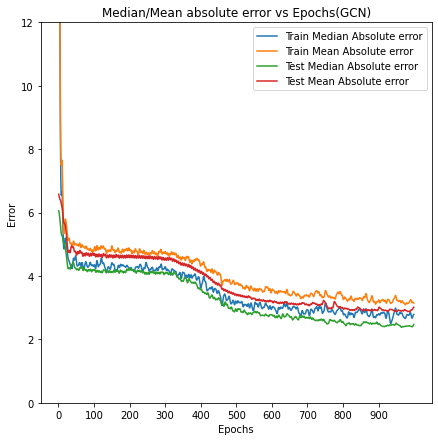

Mimimum test median absolute error 2.046445
Mimimum test mean absolute error 2.5416987


In [575]:
#Learning curves for the GCN
train_graph(train_pred, train_values, val_pred, val_values, 1000)

#Data preparation(CNN and MLP)

In [577]:
#Creating our dataset
for i in range(1,50):
  globals()['min_df_'+str(i)] = graph_dataset(globals()['G_'+str(i)])
  globals()['min_df_'+str(i)]
  for index, row in globals()['min_df_'+str(i)].iterrows():
    globals()['G_'+str(i)].add_edge(row['edge_1'], row['edge_2'])

  globals()['min_df_'+str(i)].sort_values( by = ['edge_1'], inplace = True) 
  globals()['min_df_'+str(i)]['distance'] = globals()['min_df_'+str(i)]['distance'].astype(int)
  pow={0:globals()['min_df_'+str(i)].iloc[0, 2], 1:globals()['min_df_'+str(i)].iloc[1, 2], 2:globals()['min_df_'+str(i)].iloc[2, 2], 3:globals()['min_df_'+str(i)].iloc[3, 2], 4:globals()['min_df_'+str(i)].iloc[4, 2]}
  nx.set_node_attributes(globals()['G_'+str(i)], pow, 'y')
  



In [ ]:
#Data preparation
Graph = []
coord_x = []
coord_y = []
coord_near_x = []
coord_near_y = []
distance = []
for i in range(1, 200):
    for index, row in globals()['min_df_'+str(i)].iterrows():
      Graph.append(i)
      coord_x.append(nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[row['edge_1']])
      
      coord_y.append(nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[row['edge_1']])

      distance.append(row['distance'])

In [ ]:
#Assigning values in the dataset
combined_data = pd.DataFrame(columns = ['Graph', 'coord_x', 'coord_y', 'distance'])
combined_data['Graph'] = Graph
combined_data['coord_x'] = coord_x
combined_data['coord_y'] = coord_y
combined_data['distance'] = distance


In [ ]:
#Look at the first few rows of our dataset
combined_data

,Graph,coord_x,coord_y,distance
0,1,53,66,16.28
1,1,50,50,16.28
2,1,49,56,36.77
3,1,15,70,36.77
4,1,12,48,22.20
...,...,...,...,...
990,199,57,66,26.93
991,199,47,41,26.93
992,199,46,56,31.26
993,199,15,60,31.26


#MLP

##Train/Test split

In [ ]:
#Splitting our training and testing data
x = combined_data[['coord_x', 'coord_y']]
y = combined_data[['distance']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.10, random_state=42, shuffle=False)

##Train model

In [ ]:
#Initialise our MLP regressor
clf = MLPRegressor(random_state=20, max_iter=300).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


##Evaluate for the test set

In [ ]:
#Predict on test set
pred = clf.predict(X_test)

In [ ]:
#Mean absolute error for the MLP
mean_absolute_error(y_test, pred)

In [ ]:
#Median absolute error for the MLP
median_absolute_error(y_test, pred)

6.1238212904121685

#Convolution Neural Network

##Prepare data for our CNN

In [ ]:
#Reshape values for CNN
x = x.values
x = x.reshape(x.shape[0], x.shape[1], 1)

(995, 2, 1)

##Train/Test split

In [ ]:
#Train/Test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=42, shuffle=False)

##Define our model

In [ ]:
#Define our CNN 
model = Sequential()
model.add(Conv1D(32, 2, activation="relu", input_shape=(2, 1)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.compile(loss=["mae"], optimizer="adam")

In [ ]:
#Model architecture
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1, 32)             96        
                                                                 
 flatten_8 (Flatten)         (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                2112      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


##Train CNN

In [ ]:
#Train model
history = model.fit(X_train, y_train, batch_size=32,epochs=300, verbose=1, validation_data = (X_test,y_test))

Epoch 1/300
25/25 [==============================] - 1s 14ms/step - loss: 9.8940 - val_loss: 6.5895
Epoch 2/300
25/25 [==============================] - 0s 5ms/step - loss: 6.3069 - val_loss: 5.9300
Epoch 3/300
25/25 [==============================] - 0s 6ms/step - loss: 6.0417 - val_loss: 5.8560
Epoch 4/300
25/25 [==============================] - 0s 5ms/step - loss: 5.9916 - val_loss: 5.9846
Epoch 5/300
25/25 [==============================] - 0s 5ms/step - loss: 5.9449 - val_loss: 5.8737
Epoch 6/300
25/25 [==============================] - 0s 5ms/step - loss: 5.9481 - val_loss: 6.1522
Epoch 7/300
25/25 [==============================] - 0s 5ms/step - loss: 5.9816 - val_loss: 5.8214
Epoch 8/300
25/25 [==============================] - 0s 5ms/step - loss: 5.9035 - val_loss: 5.7815
Epoch 9/300
25/25 [==============================] - 0s 6ms/step - loss: 5.8725 - val_loss: 5.7701
Epoch 10/300
25/25 [==============================] - 0s 6ms/step - loss: 5.8509 - val_loss: 5.7518
Epoch 11

##Evaluate for the test set

In [ ]:
#Predict for Test set
ypred = model.predict(X_test)

In [ ]:
#Median absolute error for the CNN
median_absolute_error(y_test, ypred)

4.1228829193115235

In [ ]:
#Nean absolute error for the CNN
mean_absolute_error(y_test, ypred)

4.757785089492798

#Federated learning with GCN

##Prepare dataset for each client

In [ ]:
#Create multiple train_loader for different clients
for i in range(0, 6):

  ran = random.randint(0,175)
  globals()['train_data_'+str(i)] = data_list[ran:ran+25]


In [ ]:
for i in range(0,6):

  globals()['train_loader_'+str(i)] = DataLoader((globals()['train_data_'+str(i)]), batch_size=10, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


##Initialise FL parameters

In [ ]:
#FL parameters
num_clients = 10
num_selected = 6
num_rounds = 150
epochs = 50
batch_size = 10

##Initialise Global model

In [ ]:
#GCN Architecture
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GATConv(2, 256)
        #self.conv2 = GATConv(256, 128)
        # self.conv3 = GCNConv(128, 56)
        # self.conv4 = GCNConv(56, 28)
        #self.conv3 = GCNConv(data.num_features, 32)
        
        #self.linear1 = torch.nn.Linear(128,64)
        self.conv3 = GCNConv(256,128)
        self.linear1 = torch.nn.Linear(128,64)
        self.linear2 = torch.nn.Linear(64,1)
        #self.linear3 = torch.nn.Linear(32,1)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        #x = self.conv2(x, edge_index)
        #x = x.relu()
        #x = torch.flatten(x)
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv3(x, edge_index)
        # x = x.relu()
        # x = self.conv4(x, edge_index)
        # x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.linear1(x)
        # x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.linear1(x)
        #x= x.relu()
        x = self.linear2(x)
        # x = self.linear3(x)
        #x= x.relu()
        
        return x

##Train model

In [ ]:
#Train client model on client data
def client_update(client_model, optimizer, train_loader, epoch):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for data in train_loader:
          total_loss = 0
          opt.zero_grad()
          data.x = data.x.to(device, dtype = torch.float)
          data.y = data.y.to(device, dtype = torch.float)
          pred = model(data.x, data.edge_index)
          loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
          #total_loss += loss.item() * data.num_graphs
    
          loss.backward()
          opt.step()
    return loss.item()

In [ ]:
#Fedaveraging
def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
      global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
      global_model.load_state_dict(global_dict)
    for model in client_models:
      model.load_state_dict(global_model.state_dict())

In [ ]:
#Define global model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = GCN(256).to(device)

In [ ]:
#Define client model as an object of the global model
client_models = [ global_model for _ in range(num_selected)]

In [ ]:
#Initialise weight parameters
for model in client_models:
    model.load_state_dict(global_model.state_dict())

In [ ]:
#Define optimiser
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Federated training with 6 clients and 150 rounds for each epoch
for r in range(num_rounds):
    print("Round", r)
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], torch.optim.Adam(model.parameters(), lr=0.001), globals()['train_data_'+str(i)], epoch=5)

Round 0


100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


Round 1


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Round 2


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


Round 3


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


Round 4


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Round 5


100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


Round 6


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Round 7


100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


Round 8


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Round 9


100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


Round 10


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


Round 11


100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


Round 12


100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Round 13


100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


Round 14


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Round 15


100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


Round 16


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


Round 17


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Round 18


100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


Round 19


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Round 20


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


Round 21


100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


Round 22


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


Round 23


100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Round 24


100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


Round 25


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


Round 26


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


Round 27


100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


Round 28


100%|██████████| 6/6 [00:01<00:00,  3.39it/s]


Round 29


100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


Round 30


100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


Round 31


100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


Round 32


100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


Round 33


100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Round 34


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Round 35


100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Round 36


100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


Round 37


100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


Round 38


100%|██████████| 6/6 [00:01<00:00,  3.30it/s]


Round 39


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Round 40


100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


Round 41


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Round 42


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Round 43


100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


Round 44


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


Round 45


100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


Round 46


100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


Round 47


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Round 48


100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


Round 49


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


Round 50


100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


Round 51


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


Round 52


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Round 53


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Round 54


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Round 55


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Round 56


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Round 57


100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


Round 58


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Round 59


100%|██████████| 6/6 [00:01<00:00,  3.32it/s]


Round 60


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Round 61


100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


Round 62


100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


Round 63


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Round 64


100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


Round 65


100%|██████████| 6/6 [00:01<00:00,  3.32it/s]


Round 66


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


Round 67


100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


Round 68


100%|██████████| 6/6 [00:01<00:00,  3.32it/s]


Round 69


100%|██████████| 6/6 [00:01<00:00,  3.32it/s]


Round 70


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Round 71


100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


Round 72


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Round 73


100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Round 74


100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Round 75


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Round 76


100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


Round 77


100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


Round 78


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Round 79


100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Round 80


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Round 81


100%|██████████| 6/6 [00:02<00:00,  2.84it/s]


Round 82


100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


Round 83


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Round 84


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Round 85


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Round 86


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Round 87


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Round 88


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Round 89


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Round 90


100%|██████████| 6/6 [00:02<00:00,  2.83it/s]


Round 91


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Round 92


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Round 93


100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


Round 94


100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


Round 95


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Round 96


100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Round 97


100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Round 98


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Round 99


100%|██████████| 6/6 [00:02<00:00,  2.84it/s]


Round 100


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Round 101


100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


Round 102


100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


Round 103


100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


Round 104


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


Round 105


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Round 106


100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


Round 107


100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


Round 108


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Round 109


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Round 110


100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Round 111


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Round 112


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Round 113


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Round 114


100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Round 115


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Round 116


100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Round 117


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Round 118


100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Round 119


100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Round 120


100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


Round 121


100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Round 122


100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Round 123


100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


Round 124


100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


Round 125


100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Round 126


100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Round 127


100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Round 128


100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Round 129


100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Round 130


100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Round 131


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Round 132


100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Round 133


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Round 134


100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Round 135


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Round 136


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Round 137


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


Round 138


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Round 139


100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Round 140


100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Round 141


100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


Round 142


100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Round 143


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Round 144


100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Round 145


100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


Round 146


100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Round 147


100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


Round 148


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


Round 149


100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


In [ ]:
#Aggregate client state for global model
server_aggregate(global_model, client_models)

##Evaluate for GCN with federated averaging

In [ ]:
#Predict for test set using the global model
pred_ = []
test_values = []
for data in test_loader:
      data.x = data.x.to(device, dtype = torch.float)
      #data.y = data.y.to(device, dtype = torch.float)
      pred = global_model(data.x, data.edge_index)

      loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
      pred = pred.detach().numpy()
      data.y = data.y.detach().numpy() 
      
      pred_.append(pred)
      test_values.append(data.y)




In [ ]:
#Conversion
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

In [ ]:
#Median absolute error 
mae = median_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))
print(mae)

1.9173469543457031


In [ ]:
#Mean absolute error 
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

mean_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


2.859435213088989

#Pruning

In [585]:
model.conv1.lin_src.weight

Parameter containing:
tensor([[-4.2510e-02,  5.9965e-02],
        [ 1.1606e-01, -4.8619e-02],
        [-2.1589e-01,  1.5472e-01],
        [-2.1155e-01,  6.6350e-02],
        [-1.2471e-01, -8.5832e-02],
        [ 1.3030e-02,  8.2306e-02],
        [ 6.7456e-02,  4.5722e-02],
        [ 5.8396e-02, -1.2893e-02],
        [-8.4711e-02, -8.4921e-02],
        [ 3.4154e-02, -7.0577e-02],
        [-1.3836e-01, -6.7823e-02],
        [-9.6197e-02,  9.9072e-02],
        [-1.8417e-01,  1.3311e-01],
        [-1.2199e-01, -1.5282e-01],
        [-1.4300e-01, -4.0384e-02],
        [-7.3585e-02,  7.4345e-02],
        [-1.7464e-01,  1.2675e-01],
        [-7.0975e-02, -6.5564e-02],
        [ 1.1588e-01, -1.2777e-01],
        [ 1.5249e-03, -9.2880e-02],
        [ 4.3662e-02,  8.6550e-03],
        [-6.1265e-02, -2.1967e-02],
        [ 1.0594e-01, -1.0405e-01],
        [ 6.9288e-02, -6.2989e-03],
        [ 4.7854e-02, -1.1517e-01],
        [-1.6043e-01, -1.1341e-01],
        [-4.6870e-02,  5.0100e-02],
      

#Initialise model

In [ ]:
#GCN Architecture
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GATConv(2, 256)
        #self.conv2 = GATConv(256, 128)
        # self.conv3 = GCNConv(128, 56)
        # self.conv4 = GCNConv(56, 28)
        #self.conv3 = GCNConv(data.num_features, 32)
        
        #self.linear1 = torch.nn.Linear(128,64)
        self.conv3 = GCNConv(256,128)
        self.linear1 = torch.nn.Linear(128,64)
        self.linear2 = torch.nn.Linear(64,1)
        #self.linear3 = torch.nn.Linear(32,1)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        #x = self.conv2(x, edge_index)
        #x = x.relu()
        #x = torch.flatten(x)
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv3(x, edge_index)
        # x = x.relu()
        # x = self.conv4(x, edge_index)
        # x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.linear1(x)
        # x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.linear1(x)
        #x= x.relu()
        x = self.linear2(x)
        # x = self.linear3(x)
        #x= x.relu()
        
        return x

In [ ]:
#Define model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(256).to(device)

In [ ]:
#Define optimiser
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#Train initial network

In [ ]:
#Train model
for epoch in range(1, 300):
  print(epoch)
  for data in train_loader:
    total_loss = 0
    optim.zero_grad()
    data.x = data.x.to(device, dtype = torch.float)
    data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)
    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    #total_loss += loss.item() * data.num_graphs
    
    loss.backward()
    optim.step()

#Evaluate on test set

In [ ]:
#Predict for test set
pred_ = []
test_values = []
for data in test_loader:
    data.x = data.x.to(device, dtype = torch.float)
    #data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)

    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    pred = pred.detach().numpy()
    data.y = data.y.detach().numpy() 
    pred_.append(pred)
    test_values.append(data.y)


In [ ]:
#Median absolute error 
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

median_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


In [ ]:
#Mean absolute error
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

mean_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


In [ ]:
#Save model weights
torch.save(model.state_dict(), 'model_weights_.pth')

##Magnitude-based pruning based on lowest L1 score

In [ ]:
#Pruning 
def prune_(proportion, GCN, layer1, layer2, layer3):
  parameters_to_prune = (
      (GCN.layer1, 'weight'),
      (GCN.layer2, 'weight'),
      (GCN.layer3, 'weight')
  )

  prune.global_unstructured(
      parameters_to_prune,
      pruning_method=prune.L1Unstructured,
      amount=proportion,
  )

In [ ]:
#Load model weights
model.load_state_dict(torch.load('model_weights_.pth'))

In [ ]:
#Apply pruning
prune_(0.1, model, conv1.lin_src, conv3.lin, linear1)

###Re-train

In [ ]:
#Re-Train model
for epoch in range(1, 300):
  print(epoch)
  for data in train_loader:
    total_loss = 0
    optim.zero_grad()
    data.x = data.x.to(device, dtype = torch.float)
    data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)
    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    #total_loss += loss.item() * data.num_graphs
    
    loss.backward()
    optim.step()

###Evaluate on test set

In [ ]:
#Predict for test set
pred_ = []
test_values = []
for data in test_loader:
    data.x = data.x.to(device, dtype = torch.float)
    #data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)

    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    pred = pred.detach().numpy()
    data.y = data.y.detach().numpy() 
    pred_.append(pred)
    test_values.append(data.y)


In [ ]:
#Median absolute error 
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

median_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


In [ ]:
#Mean absolute error
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

mean_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


##Magnitude-based pruning based on threshold

In [ ]:
#Initialise model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(2, 256)
        self.conv2 = GCNConv(256, 128)
        #self.conv3 = GCNConv(128, 1)
        #self.conv3 = GCNConv(data.num_features, 32)
        self.linear1 = torch.nn.Linear(128,1)
        # self.linear2 = torch.nn.Linear(56,1)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        # x = self.conv3(x, edge_index)
        # x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        x = self.linear1(x)
        # x = x.relu()
        # x = self.linear2(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(256).to(device)

In [ ]:
#Threshold pruning
class ThresholdPruning(prune.BasePruningMethod):
    PRUNING_TYPE = "unstructured"

    def __init__(self, threshold):
        self.threshold = threshold

    def compute_mask(self, tensor, default_mask):
        return torch.abs(tensor) > self.threshold

In [ ]:
#Load previous weights
model.load_state_dict(torch.load('model_weights_.pth'))

<All keys matched successfully>

In [ ]:
#Mention parameters
parameters_to_prune = (
    (model.conv1.lin_src, 'weight'),
    (model.conv3.lin, 'weight'),
    (model.linear1, 'weight')
)

prune.global_unstructured(
    parameters_to_prune, pruning_method=ThresholdPruning, threshold=0.01
)

###Re-train

In [ ]:
for epoch in range(1, 300):
  print(epoch)
  for data in train_loader:
    total_loss = 0
    optim.zero_grad()
    data.x = data.x.to(device, dtype = torch.float)
    data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)
    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    #total_loss += loss.item() * data.num_graphs
    
    loss.backward()
    optim.step()

###Evaluate on test set

In [ ]:
#Predict for test set
pred_ = []
test_values = []
for data in test_loader:
    data.x = data.x.to(device, dtype = torch.float)
    #data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)

    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    pred = pred.detach().numpy()
    data.y = data.y.detach().numpy() 
    pred_.append(pred)
    test_values.append(data.y)


In [ ]:
#Median absolute error 
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

median_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


In [ ]:
#Mean absolute error
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

mean_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))
